<a href="https://colab.research.google.com/github/Malaiyarasan/crowd-management-drone-vision/blob/main/notebooks/crowd_management_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1 - install (Colab usually already has these)
!pip install -q tensorflow==2.19.0 matplotlib pillow gradio


In [2]:
# Cell 1b - imports
import os, random, zipfile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print("TF", tf.__version__)


TF 2.19.0


In [3]:
# Cell 2 - generate synthetic crowd images
from pathlib import Path
import numpy as np, cv2, random
OUT = Path("data/crowd_demo")
if OUT.exists():
    shutil.rmtree(OUT)

labels = ["low","medium","high"]
counts = {"low":8, "medium":20, "high":45}  # number of "people" drawn per image

def make_crowd_image(n_people, size=(224,224)):
    h,w = size
    img = np.full((h,w,3), 60, dtype=np.uint8)  # slightly dark ground
    for _ in range(n_people):
        x = random.randint(0,w-1)
        y = random.randint(0,h-1)
        r = random.randint(2,6)
        color = tuple([int(150 + random.random()*100)]*3)  # brighter blobs
        cv2.circle(img, (x,y), r, color, -1)
    # add light Gaussian blur and contrast variation
    img = cv2.GaussianBlur(img, (3,3), 0)
    return img

OUT.mkdir(parents=True, exist_ok=True)
for lab in labels:
    p = OUT / lab
    p.mkdir(exist_ok=True)
    # generate 120 images per class for demo
    for i in range(120):
        n = counts[lab] + random.randint(-3,3)
        img = make_crowd_image(n, size=(224,224))
        cv2.imwrite(str(p / f"{lab}_{i:03d}.png"), img)

print("Created demo images at", OUT)


Created demo images at data/crowd_demo


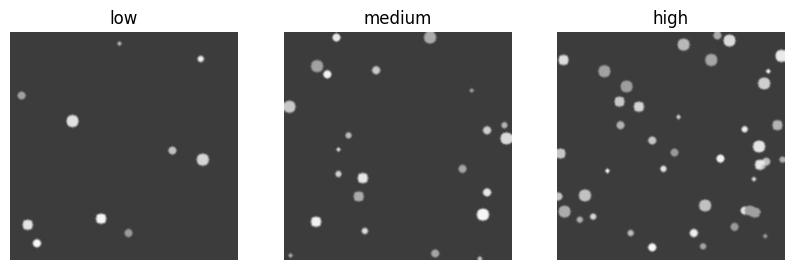

In [4]:
# Cell 3 - preview a few images
import matplotlib.pyplot as plt
from random import choice
base = Path("data/crowd_demo")
plt.figure(figsize=(10,4))
for i,lab in enumerate(labels):
    img = cv2.imread(str(choice(list((base/lab).glob("*.png")))))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1,3,i+1); plt.imshow(img); plt.title(lab); plt.axis('off')
plt.show()


In [5]:
# Cell 4 - dataloaders
IMG_SIZE = (224,224)
BATCH = 16

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.18,
                             rotation_range=10, width_shift_range=0.05, height_shift_range=0.05,
                             zoom_range=0.1, horizontal_flip=True)

train_gen = datagen.flow_from_directory("data/crowd_demo", target_size=IMG_SIZE, batch_size=BATCH,
                                        class_mode="categorical", subset="training", shuffle=True)
val_gen = datagen.flow_from_directory("data/crowd_demo", target_size=IMG_SIZE, batch_size=BATCH,
                                      class_mode="categorical", subset="validation", shuffle=False)


Found 297 images belonging to 3 classes.
Found 63 images belonging to 3 classes.


In [6]:
# Cell 5 - model
def build_cnn(input_shape=(224,224,3), n_classes=3):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(n_classes, activation='softmax')(x)
    model = models.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_cnn(input_shape=IMG_SIZE+(3,), n_classes=train_gen.num_classes)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,147 (430.26 KB)

 Trainable params: 110,147 (430.26 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Cell 6 - train
EPOCHS = 10
history = model.fit(train_gen, epochs=EPOCHS, validation_data=val_gen)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.3848 - loss: 1.0984 - val_accuracy: 0.3333 - val_loss: 1.0893
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.3648 - loss: 1.0877 - val_accuracy: 0.3333 - val_loss: 1.0767
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.3890 - loss: 1.0658 - val_accuracy: 0.3492 - val_loss: 1.0491
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.3801 - loss: 1.0433 - val_accuracy: 0.4444 - val_loss: 0.9790
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.4393 - loss: 0.9738 - val_accuracy: 0.3333 - val_loss: 0.8836
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.4597 - loss: 0.8205 - val_accuracy: 1.0000 - val_loss: 0.7084
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8481 - loss: 0.6308 - val_accuracy: 0.9365 - val_loss: 0.4024
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9485 - loss: 0.3205 - val_accuracy: 0.9524 - val_loss:

In [9]:
# Cell 7 - save model
Path("model").mkdir(exist_ok=True)
model.save("model/crowd_cnn_demo.h5")
print("Saved model/model_crowd_demo.h5")


Saved model/model_crowd_demo.h5


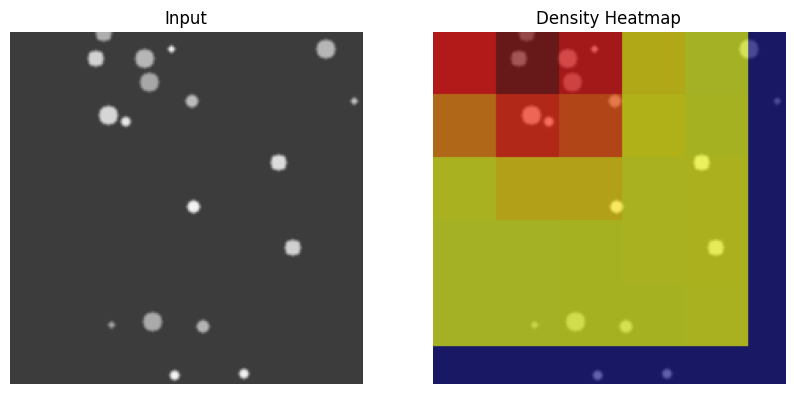

In [10]:
# Cell 8 - sliding-window density map + overlay
import numpy as np
from tqdm import tqdm

def patch_density_map(image, model, patch=64, stride=32):
    # image: RGB uint8 (H,W,3)
    H,W,_ = image.shape
    heat = np.zeros((H,W), dtype=float)
    counts = np.zeros((H,W), dtype=float)
    for y in range(0, H-patch+1, stride):
        for x in range(0, W-patch+1, stride):
            crop = image[y:y+patch, x:x+patch]
            img = cv2.resize(crop, (224,224)) / 255.0
            pred = model.predict(img[None,...], verbose=0)[0]  # [low,med,high]
            # use class index weights to create a density score: low=0.1, med=0.5, high=1.0
            score = pred.dot(np.array([0.1,0.5,1.0]))
            heat[y:y+patch, x:x+patch] += score
            counts[y:y+patch, x:x+patch] += 1
    counts[counts==0] = 1e-6
    heat = heat / counts
    # normalize 0..1
    heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-8)
    return heat

def overlay_heatmap(image, heat, alpha=0.5, cmap=cv2.COLORMAP_JET):
    # image: RGB uint8, heat: 0..1
    heat_uint8 = (heat*255).astype(np.uint8)
    heat_color = cv2.applyColorMap(heat_uint8, cmap)
    heat_color = cv2.cvtColor(heat_color, cv2.COLOR_BGR2RGB)
    combined = (image.astype(float)*(1-alpha) + heat_color.astype(float)*alpha).astype(np.uint8)
    return combined

# quick demo using one sample
img = cv2.cvtColor(cv2.imread(str(list((Path('data/crowd_demo/medium').glob('*.png')))[0])), cv2.COLOR_BGR2RGB)
heat = patch_density_map(img, model, patch=80, stride=40)
ov = overlay_heatmap(img, heat, alpha=0.6)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(img); plt.title("Input"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(ov); plt.title("Density Heatmap"); plt.axis('off')
plt.show()


In [11]:
# Cell 9 - Gradio UI to upload image and see heatmap + label
import gradio as gr
from PIL import Image

def predict_and_heat(image):
    # image is PIL image
    img = np.array(image.convert('RGB'))
    img_resized = cv2.resize(img, (224,224)) / 255.0
    pred = model.predict(img_resized[None,...])[0]
    cls_idx = np.argmax(pred)
    cls_name = list(train_gen.class_indices.keys())[list(train_gen.class_indices.values()).index(cls_idx)]
    heat = patch_density_map(img, model, patch=96, stride=48)
    ov = overlay_heatmap(img, heat, alpha=0.6)
    return cls_name, ov

iface = gr.Interface(
    fn=predict_and_heat,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Textbox(label="Predicted density"), gr.Image(label="Density heatmap")],
    title="Crowd Density Classifier & Heatmap (Demo)",
    description="Upload an aerial/tilted image of crowd. Demo uses synthetic dataset."
)
iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cd67d1e1d508e42c76.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
